In [2]:
# --- Setup and Libraries ---
import os, glob
import random
import librosa
import pandas as pd
import numpy as np
from tqdm import tqdm
import opensmile
import matplotlib.pyplot as plt
import seaborn as sns
import soundfile as sf

# ML libraries
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Imbalance handling
from imblearn.over_sampling import SMOTE

# Deep learning
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers


In [4]:
# --- Dataset Paths ---
data_paths = {
    "Healthy": r"C:\Users\USER\OneDrive\Desktop\Code\s3\Speech project\New_speech_dataset\Healthy",
    "Parkinson": r"C:\Users\USER\OneDrive\Desktop\Code\s3\Speech project\New_speech_dataset\parkinson"
}

# --- Tasks to include ---
required_tasks = ["B1", "B2", "FB1",
                  "VA1", "VA2", "VE1", "VE2", "VI1", "VI2",
                  "VO1", "VO2", "VU1", "VU2"]

# --- Collect files ---
paths = {"healthy": [], "parkinson": []}
for group, path in data_paths.items():
    all_group_files = glob.glob(os.path.join(path, '**', '*.wav'), recursive=True)
    filtered_files = [f for f in all_group_files if any(task in os.path.basename(f).upper() for task in required_tasks)]
    if "Healthy" in group:
        paths["healthy"].extend(filtered_files)
    elif "Parkinson" in group:
        paths["parkinson"].extend(filtered_files)

all_files = paths["healthy"] + paths["parkinson"]


In [6]:
def preprocess_audio(file_path, target_sr=16000):
    try:
        y, sr = librosa.load(file_path, sr=None, mono=True)
        if sr != target_sr:
            y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
            sr = target_sr
        y = librosa.util.normalize(y)
        y, _ = librosa.effects.trim(y)
        sf.write(file_path, y, sr)
        return file_path
    except:
        return None

all_files_preprocessed = []
for f in tqdm(all_files, desc="Preprocessing audio files"):
    processed_file = preprocess_audio(f)
    if processed_file:
        all_files_preprocessed.append(processed_file)

print("Preprocessing complete samples:", len(all_files_preprocessed))


Preprocessing audio files:   0%|                                                               | 0/585 [00:00<?, ?it/s]D:\jupyter\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,
Preprocessing audio files: 100%|█████████████████████████████████████████████████████| 585/585 [00:11<00:00, 53.15it/s]

Preprocessing complete samples: 585


File: C:\Users\USER\OneDrive\Desktop\Code\s3\Speech project\New_speech_dataset\Healthy\AGNESE P\B1APGANRET55F170320171104.wav
Duration (sec): 101.35  | Sampling rate: 16000


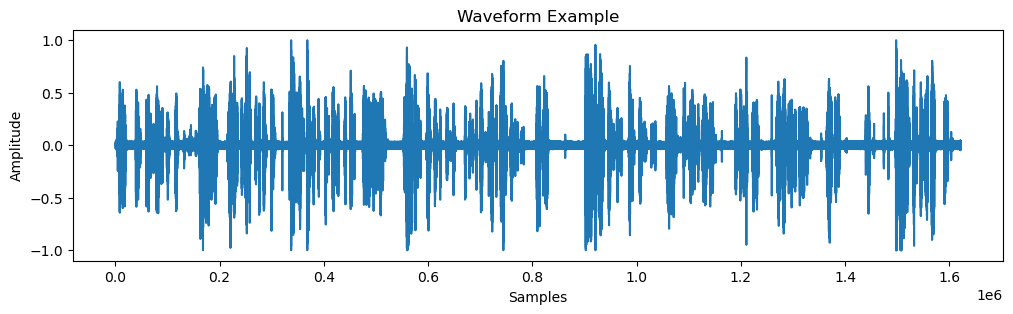

In [8]:
# --- Inspect a sample preprocessed file ---
sample_file = all_files_preprocessed[0]  # take first preprocessed audio
y, sr = librosa.load(sample_file, sr=None)  # load with original sampling rate

# Print file info
print("File:", sample_file)
print("Duration (sec):", round(len(y)/sr, 2), " | Sampling rate:", sr)

# Plot waveform
import matplotlib.pyplot as plt
plt.figure(figsize=(12,3))
plt.plot(y)
plt.title("Waveform Example")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()


In [14]:
# --- Organize preprocessed files by group ---
all_files_preprocessed_dict = {
    "Healthy": [f for f in all_files_preprocessed if "Healthy" in f or "healthy" in f],
    "Parkinson": [f for f in all_files_preprocessed if "Parkinson" in f or "parkinson" in f]
}

# --- Linear Feature Extraction using OpenSMILE ---
import opensmile
import pandas as pd
from tqdm import tqdm

# Initialize OpenSMILE for ComParE 2016 functionals
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_level=opensmile.FeatureLevel.Functionals,
)

features_list = []
labels_list = []
files_list = []

# Define labels: 0 = Healthy, 1 = Parkinson
label_map = {
    "Healthy": 0,
    "Parkinson": 1
}

# Loop over preprocessed files
for group, file_list in all_files_preprocessed_dict.items():
    for f in tqdm(file_list, desc=f"Processing {group}"):
        try:
            feat = smile.process_file(f).values.flatten()
            features_list.append(feat)
            labels_list.append(label_map[group])
            files_list.append(f)
        except Exception as e:
            print(f"Error processing {f}: {e}")

# Convert to DataFrame
feature_names = smile.feature_names
df_features = pd.DataFrame(features_list, columns=feature_names)
df_features["label"] = labels_list
df_features["filename"] = files_list

print("Feature extraction complete!")
print("Shape of feature DataFrame:", df_features.shape)
print(df_features["label"].value_counts())


Processing Parkinson: 100%|██████████████████████████████████████████████████████████| 312/312 [01:34<00:00,  3.29it/s]


Feature extraction complete!
Shape of feature DataFrame: (585, 6375)
label
1    312
0    273
Name: count, dtype: int64


In [16]:
# --- Feature Scaling and Variance Thresholding ---
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

# Separate features and labels
X = df_features.drop(columns=["label", "filename"])
y = df_features["label"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled features mean:", X_scaled.mean(), " | std:", X_scaled.std())

# Convert scaled features back to DataFrame
df_scaled = pd.DataFrame(X_scaled, columns=X.columns)
df_scaled["label"] = y.values
print(df_scaled.head())

# Remove near-constant features (variance < 0.01)
selector = VarianceThreshold(threshold=0.01)
X_reduced = selector.fit_transform(X_scaled)

print("Original number of features:", X_scaled.shape[1])
print("Number of features after variance thresholding:", X_reduced.shape[1])


Scaled features mean: 1.0231994e-12  | std: 0.9999999
   audspec_lengthL1norm_sma_range  audspec_lengthL1norm_sma_maxPos  \
0                        2.030377                         0.184644   
1                        3.461410                         0.103885   
2                        1.769128                         0.165218   
3                        0.408658                        -0.641077   
4                        0.641011                        -0.649705   

   audspec_lengthL1norm_sma_minPos  audspec_lengthL1norm_sma_quartile1  \
0                        -1.130131                           -0.798607   
1                        -1.130059                           -0.774714   
2                        -1.129182                           -0.740873   
3                        -1.126731                            1.339274   
4                        -1.126476                            1.659651   

   audspec_lengthL1norm_sma_quartile2  audspec_lengthL1norm_sma_quartile3  \
0  

In [18]:
# --- Speaker-Independent Train/Test Split ---
import random

# Extract participant IDs from filenames
# Assuming folder structure: .../Healthy/ParticipantID/file.wav
df_features['participant'] = df_features['filename'].apply(lambda x: x.split(os.sep)[-2])

# Get unique participants per group
participants = {
    "Healthy": df_features[df_features['label']==0]['participant'].unique().tolist(),
    "Parkinson": df_features[df_features['label']==1]['participant'].unique().tolist()
}

# Split participants into train/test (80/20)
train_participants = []
test_participants = []

for group, plist in participants.items():
    random.seed(42)
    random.shuffle(plist)
    split_idx = int(0.8 * len(plist))
    train_participants += plist[:split_idx]
    test_participants += plist[split_idx:]

# Assign files to train/test based on participant
train_mask = df_features['participant'].isin(train_participants)
test_mask = df_features['participant'].isin(test_participants)

X_train = X_reduced[train_mask]
y_train = y.values[train_mask]
X_test = X_reduced[test_mask]
y_test = y.values[test_mask]

print("Speaker-independent split done!")
print("Train samples:", len(y_train))
print("Test samples:", len(y_test))


Speaker-independent split done!
Train samples: 455
Test samples: 130


In [26]:
print("Before SMOTE:\n", pd.Series(y_train).value_counts())

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print("After SMOTE:\n", pd.Series(y_train_bal).value_counts())


Before SMOTE:
 1    247
0    208
Name: count, dtype: int64
After SMOTE:
 0    247
1    247
Name: count, dtype: int64


In [28]:
# --- Traditional Machine Learning Models with SMOTE-balanced training ---
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Use SMOTE-balanced training set
X_train_bal, y_train_bal = X_train_bal, y_train_bal  # Already computed after SMOTE

# --- 1. SVM (Linear Kernel) ---
svm_clf = SVC(kernel='linear', probability=True, random_state=42)
svm_clf.fit(X_train_bal, y_train_bal)
y_pred_svm = svm_clf.predict(X_test)

# --- 2. Random Forest ---
rf_clf = RandomForestClassifier(n_estimators=200, random_state=42)
rf_clf.fit(X_train_bal, y_train_bal)
y_pred_rf = rf_clf.predict(X_test)

# --- 3. KNN ---
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train_bal, y_train_bal)
y_pred_knn = knn_clf.predict(X_test)

# --- 4. Naive Bayes ---
nb_clf = GaussianNB()
nb_clf.fit(X_train_bal, y_train_bal)
y_pred_nb = nb_clf.predict(X_test)

# --- Classification Reports ---
print("SVM Classification Report:\n", classification_report(y_test, y_pred_svm))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("KNN Classification Report:\n", classification_report(y_test, y_pred_knn))
print("Naive Bayes Classification Report:\n", classification_report(y_test, y_pred_nb))


SVM Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        65
           1       1.00      0.97      0.98        65

    accuracy                           0.98       130
   macro avg       0.99      0.98      0.98       130
weighted avg       0.99      0.98      0.98       130

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97        65
           1       0.98      0.95      0.97        65

    accuracy                           0.97       130
   macro avg       0.97      0.97      0.97       130
weighted avg       0.97      0.97      0.97       130

KNN Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.97      0.85        65
           1       0.96      0.69      0.80        65

    accuracy                           0.83       130
   macro avg       0.86      0.83 

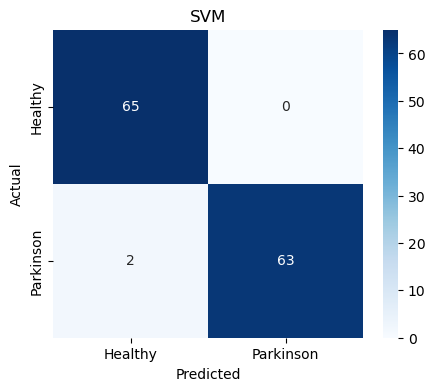

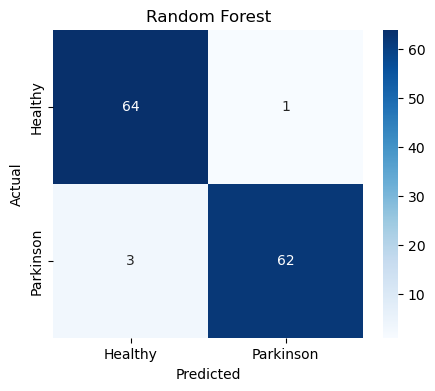

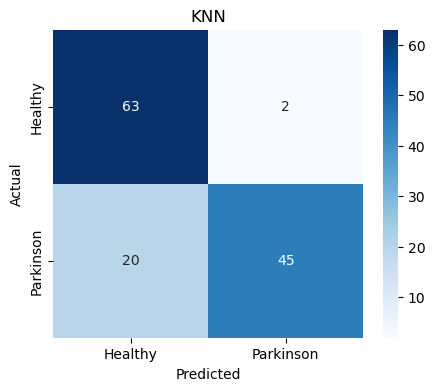

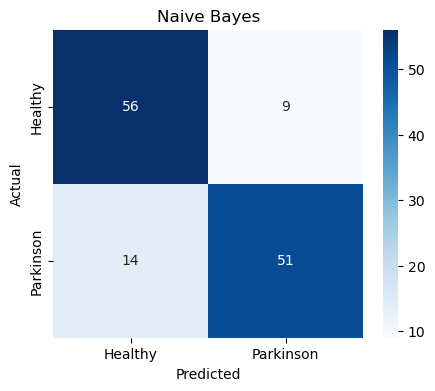

In [30]:
# --- Confusion Matrix Function ---
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Healthy", "Parkinson"],
                yticklabels=["Healthy", "Parkinson"])
    plt.title(title)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(y_test, y_pred_svm, "SVM")
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")
plot_confusion_matrix(y_test, y_pred_knn, "KNN")
plot_confusion_matrix(y_test, y_pred_nb, "Naive Bayes")

In [44]:
# --- Deep Learning Preparation ---
from sklearn.preprocessing import StandardScaler
import numpy as np

# --- Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)  # Fit on SMOTE-balanced training set
X_test_scaled = scaler.transform(X_test)           # Transform original test set

# --- Reshape for CNN+BiLSTM ---
timesteps = 10
feature_dim = X_train_scaled.shape[1] // timesteps

# truncate features to match timesteps * feature_dim
X_train_dl = X_train_scaled[:, :timesteps*feature_dim].reshape((X_train_scaled.shape[0], timesteps, feature_dim))
X_test_dl = X_test_scaled[:, :timesteps*feature_dim].reshape((X_test_scaled.shape[0], timesteps, feature_dim))

print("DL input shapes - Train:", X_train_dl.shape, " | Test:", X_test_dl.shape)
print("X_train_dl min/max:", X_train_dl.min(), " | X_test_dl min/max:", X_test_dl.max())


DL input shapes - Train: (494, 10, 637)  | Test: (130, 10, 637)
X_train_dl min/max: -17.371588  | X_test_dl min/max: 60.40281


In [46]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

model = models.Sequential([
    layers.Conv1D(64, 3, activation='relu', padding='same', input_shape=(timesteps, feature_dim)),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),

    layers.Conv1D(128, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),

    layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.3)),
    layers.Bidirectional(layers.LSTM(64, dropout=0.3)),

    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# --- Callbacks ---
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)


D:\jupyter\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [48]:
from sklearn.utils import class_weight

# Compute class weights
class_weights_array = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_bal),
    y=y_train_bal
)
class_weights = {i: class_weights_array[i] for i in range(len(class_weights_array))}

# Train the model
history = model.fit(
    X_train_dl, y_train_bal,
    validation_data=(X_test_dl, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights,
    verbose=1
)


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.5092 - loss: 1.2827 - val_accuracy: 0.5000 - val_loss: 1.0336 - learning_rate: 1.0000e-04
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5525 - loss: 1.1925 - val_accuracy: 0.5000 - val_loss: 1.0314 - learning_rate: 1.0000e-04
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6373 - loss: 1.0352 - val_accuracy: 0.5000 - val_loss: 1.0285 - learning_rate: 1.0000e-04
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6699 - loss: 0.9534 - val_accuracy: 0.5000 - val_loss: 1.0236 - learning_rate: 1.0000e-04
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7301 - loss: 0.8703 - val_accuracy: 0.5000 - val_loss: 1.0168 - learning_rate: 1.0000e-04
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7324 - loss: 0.8943 - val_accuracy: 0.5077 - val_loss: 1.0086 - learning_rate: 1.0000e-04
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 

In [50]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 10, 64)              │         122,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 10, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 5, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 5, 128)              │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 5, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 2, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 2, 256)              │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,926,533 (7.35 MB)

 Trainable params: 641,793 (2.45 MB)

 Non-trainable params: 1,152 (4.50 KB)

 Optimizer params: 1,283,588 (4.90 MB)

In [52]:
# --- Evaluate ---
y_pred_prob = model.predict(X_test_dl)
y_pred_dl = (y_pred_prob >= 0.5).astype(int).flatten()

from sklearn.metrics import classification_report, confusion_matrix

print("CNN+BiLSTM Classification Report:\n", classification_report(y_test, y_pred_dl))




5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step
CNN+BiLSTM Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.95        65
           1       0.95      0.94      0.95        65

    accuracy                           0.95       130
   macro avg       0.95      0.95      0.95       130
weighted avg       0.95      0.95      0.95       130



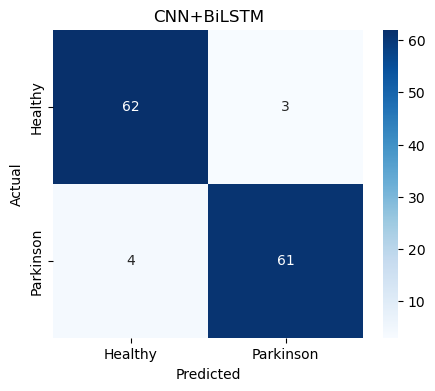

In [54]:
# --- Plot Confusion Matrix ---
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Healthy", "Parkinson"],
                yticklabels=["Healthy", "Parkinson"])
    plt.title(title)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

plot_confusion_matrix(y_test, y_pred_dl, "CNN+BiLSTM")

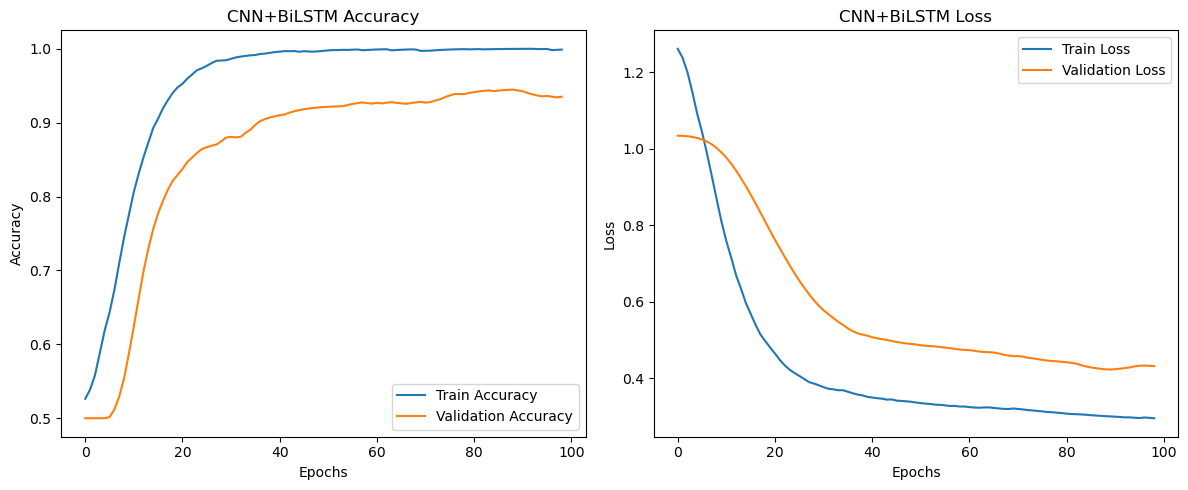

In [58]:
import matplotlib.pyplot as plt

# --- Smooth curves function ---
def smooth_curve(values, weight=0.8):
    smoothed = []
    last = values[0]
    for point in values:
        last = last * weight + (1 - weight) * point
        smoothed.append(last)
    return smoothed

# --- Smooth training curves ---
train_acc_smooth = smooth_curve(history.history['accuracy'])
val_acc_smooth = smooth_curve(history.history['val_accuracy'])
train_loss_smooth = smooth_curve(history.history['loss'])
val_loss_smooth = smooth_curve(history.history['val_loss'])

# --- Plot ---
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(train_acc_smooth, label='Train Accuracy')
plt.plot(val_acc_smooth, label='Validation Accuracy')
plt.title('CNN+BiLSTM Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


# Loss
plt.subplot(1,2,2)
plt.plot(train_loss_smooth, label='Train Loss')
plt.plot(val_loss_smooth, label='Validation Loss')
plt.title('CNN+BiLSTM Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.tight_layout()
plt.show()


In [60]:
from sklearn.metrics import accuracy_score, f1_score

# List of models and their predictions
model_names = ['SVM', 'Random Forest', 'KNN', 'Naive Bayes', 'CNN+BiLSTM']
y_preds = [y_pred_svm, y_pred_rf, y_pred_knn, y_pred_nb, y_pred_dl]

# Compute accuracy and F1-score
accuracy = [accuracy_score(y_test, y_pred) for y_pred in y_preds]
f1_scores = [f1_score(y_test, y_pred) for y_pred in y_preds]

# Print results
for i, name in enumerate(model_names):
    print(f"{name} - Test Accuracy: {accuracy[i]:.4f}, F1-score: {f1_scores[i]:.4f}")


SVM - Test Accuracy: 0.9846, F1-score: 0.9844
Random Forest - Test Accuracy: 0.9692, F1-score: 0.9688
KNN - Test Accuracy: 0.8308, F1-score: 0.8036
Naive Bayes - Test Accuracy: 0.8231, F1-score: 0.8160
CNN+BiLSTM - Test Accuracy: 0.9462, F1-score: 0.9457


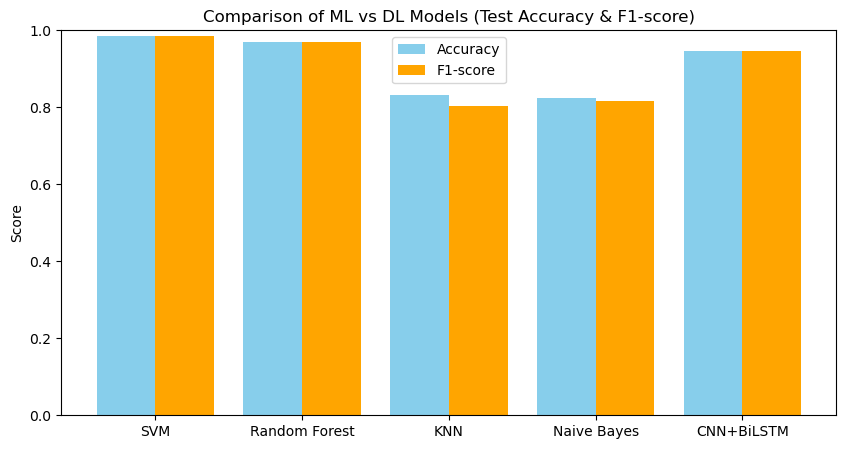

In [62]:
#  Plot comparison
import matplotlib.pyplot as plt
x = range(len(model_names))

plt.figure(figsize=(10,5))

# Accuracy bars
plt.bar(x, accuracy, width=0.4, label='Accuracy', color='skyblue', align='center')

# F1-score bars
plt.bar([i + 0.4 for i in x], f1_scores, width=0.4, label='F1-score', color='orange', align='center')

plt.xticks([i + 0.2 for i in x], model_names)
plt.ylabel('Score')
plt.ylim(0, 1)
plt.title('Comparison of ML vs DL Models (Test Accuracy & F1-score)')
plt.legend()
plt.show()